In [104]:
import pickle
import pandas as pd
data_dict = pickle.load(open('data/data_dict/housing.pkl', 'rb'))
data = []
feature_names = ['index']
first = True
for key in data_dict:
    row = [key]
    for label, val in data_dict[key].items():
        if first:
            feature_names.append(label)
        row.append(val)
    data.append(row)
    first = False
df = pd.DataFrame(data, columns=feature_names)
df.index = df['index']
df.drop(columns=['index'], inplace=True)

# for all cols that are not numeric, convert to numeric
for col in df.columns:
    if not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f'Converted {col} to numeric')

In [140]:
df.dropna(inplace=True)
df.shape

(20433, 9)

## Benchmark Models

### Logistic Regression

RandomForest accuracies: [0.75581111 0.66772694 0.80890629 0.73568282 0.82550171]
XGBoost accuracies: [0.77195987 0.64252508 0.76633227 0.71879589 0.81791483]


/Users/kylecox/opt/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kylecox/opt/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

LogisticRegression accuracies: [0.81918277 0.82554441 0.78615121 0.77435144 0.81399902]
Tree accuracies: [0.76070467 0.59481282 0.70491803 0.68208517 0.74351444]


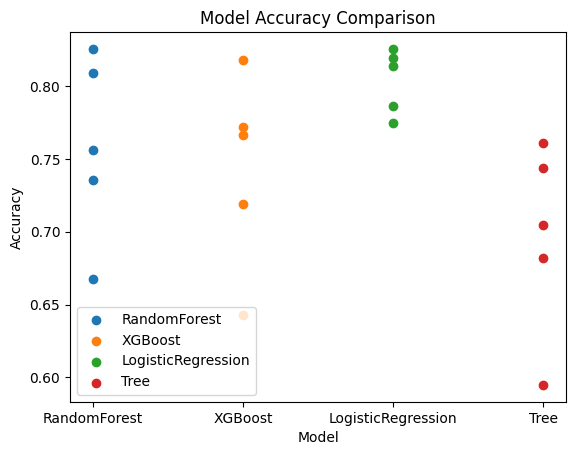

In [147]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from matplotlib import pyplot as plt
# import decision tree
from sklearn import tree

X = df.drop('Label', axis=1)
y = df['Label']

# Define models
models = [
    ('RandomForest', RandomForestClassifier()),
    ('XGBoost', xgb.XGBClassifier()),
    ('LogisticRegression', LogisticRegression()),
    ('Tree', tree.DecisionTreeClassifier())
]

# Define metric
scoring = make_scorer(accuracy_score)

# Apply 5-fold cross-validation and store results
results = []
for name, model in models:
    cv_scores = cross_val_score(model, X, y, cv=5, scoring=scoring)
    results.append((name, cv_scores))
    print(f'{name} accuracies: {cv_scores}')

# Plot results
fig, ax = plt.subplots()

for i, (name, scores) in enumerate(results):
    ax.scatter([name]*len(scores), scores, label=name)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison')
ax.legend()

plt.show()

/Users/kylecox/opt/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kylecox/opt/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

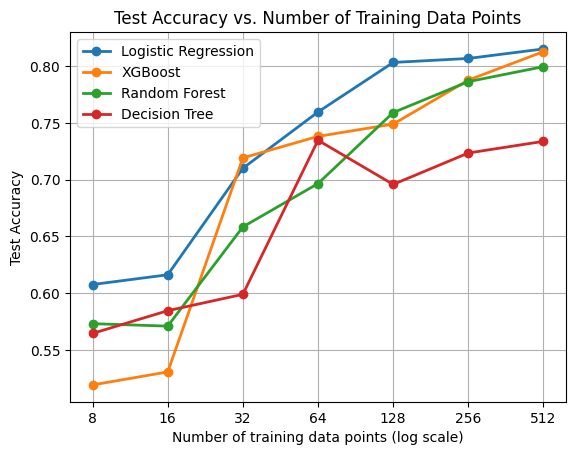

In [149]:
# Test logistic regression with different number of training data points: 4, 8, 16, 32, 64, 128, 256
import numpy as np

model = LogisticRegression()
test_size = 400
num_train_data = [4, 8, 16, 32, 64, 128, 256]
folds = 5
test_scores = []
def model_evaluation(model):
    test_size = 10000
    num_train_data = [4, 8, 16, 32, 64, 128, 256]
    folds = 5
    test_scores = []
    for num in num_train_data:
        num_train_scores = []
        for _ in range(folds):
            X_train = X.sample(num)
            y_train = y[X_train.index]
            X_test = X.drop(X_train.index)[:test_size]
            y_test = y[X_test.index]
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                num_train_scores.append(accuracy_score(y_test, y_pred))
            except:
                num_train_scores.append(np.nan)
        test_scores.append(sum(num_train_scores) / len(num_train_scores))

    return test_scores

# Initialize models
models = [LogisticRegression(), XGBClassifier(), RandomForestClassifier(), tree.DecisionTreeClassifier()]
model_names = ['Logistic Regression', 'XGBoost', 'Random Forest', 'Decision Tree']
num_train_data = [8, 16, 32, 64, 128, 256, 512]

# dot plot of test scores vs. number of training data points
fig, ax = plt.subplots()

for model, model_name in zip(models, model_names):
    test_scores = model_evaluation(model)
    ax.plot(num_train_data, test_scores, marker='o', linewidth=2, label=model_name)

ax.set_xscale('log', base=2)  # set log scale
ax.set_xticks(num_train_data)  # set custom ticks
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # to keep the x-ticks as integers

ax.set_xlabel('Number of training data points (log scale)')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy vs. Number of Training Data Points')
ax.grid(True)
ax.legend()

plt.show()


/Users/kylecox/opt/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kylecox/opt/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

AttributeError: 'AxesSubplot' object has no attribute 'set_xcale'

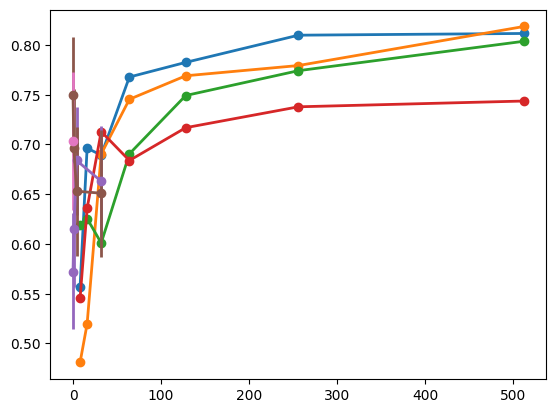

In [159]:
# additional data
no_hypothesis_results = {'num_shots': [0, 1, 4, 32], 'acc': [.572, .615, .684, .663], 'ci': [(0.514, 0.631), (0.557, 0.672), (0.629, 0.738), (0.607, 0.719)]}
hypothesis_64_results = {'num_shots': [0, 1, 4, 32], 'acc': [.75, .696, .653, .651], 'ci': [(.692, .808), (.636, .756), (.588, .718), (.587, .715)]}
hypothesis_4_results = {'num_shots': [0], 'acc': [.703], 'ci': [(.634, .773)]}

additional_data = [no_hypothesis_results, hypothesis_64_results, hypothesis_4_results]
additional_data_names = ['No Hypothesis', 'Hypothesis 64', 'Hypothesis 4']

# dot plot of test scores vs. number of training data points
fig, ax = plt.subplots()

for model, model_name in zip(models, model_names):
    test_scores = model_evaluation(model)
    ax.plot(num_train_data, test_scores, marker='o', linewidth=2, label=model_name)

for data, data_name in zip(additional_data, additional_data_names):
    acc = data['acc']
    ci = np.array(data['ci'])
    error = np.abs(ci - np.array(acc)[:, None]).T
    ax.errorbar(data['num_shots'], acc, yerr=error, marker='o', linewidth=2, label=data_name)

ax.set_xscale('log', base=2)  # set log scale with base 2
ax.set_xticks([0, 1, 2, 4, 8, 16, 32, 64, 128, 256])  # set custom ticks
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # to keep the x-ticks as integers

ax.set_xlabel('Number of training data points (log scale)')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy vs. Number of Training Data Points')
ax.grid(True)
ax.legend()

plt.show()

few-shot, no-hypothesis, 0
Accuracy: 0.572
Confidence interval: 0.514 0.631
few-shot, no-hypothesis, 1
Accuracy: 0.615
Confidence interval: 0.557 0.672
few-shot, no-hypothesis, 4
Accuracy: 0.684
Confidence interval: 0.629 0.738
few-shot, no-hypothesis, 32
Accuracy: 0.663
Confidence interval: 0.607 0.719
hypothesis, 4, 0, hypothesis_0
Accuracy: 0.703
Confidence interval: 0.634 0.773
hypothesis, 64, 0, hypothesis_0
Accuracy: 0.75
Confidence interval: 0.692 0.808
hypothesis, 64, 1, hypothesis_0
Accuracy: 0.696
Confidence interval: 0.636 0.756
hypothesis, 64, 4, hypothesis_0
Accuracy: 0.653
Confidence interval: 0.588 0.718
hypothesis, 64, 32, hypothesis_0
Accuracy: 0.651
Confidence interval: 0.587 0.715

In [136]:
test_scores

[nan,
 0.7839999999999999,
 0.8085000000000001,
 0.8255000000000001,
 0.8559999999999999,
 0.8869999999999999,
 0.8909999999999998]

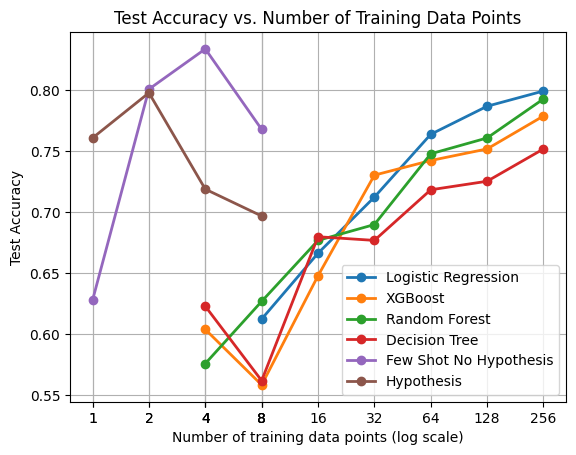

In [99]:
# Your new data
few_shot_results = {'num_shots': [1, 2, 4, 8], 'acc': [0.628, 0.801, 0.834, 0.768]}
hypothesis_results = {'num_shots': [1, 2, 4, 8], 'acc': [0.761, 0.798, 0.719, 0.697]}

# Continue your code
models = [LogisticRegression(), XGBClassifier(), RandomForestClassifier(), tree.DecisionTreeClassifier()]
model_names = ['Logistic Regression', 'XGBoost', 'Random Forest', 'Decision Tree']

num_train_data = [4, 8, 16, 32, 64, 128, 256]

# dot plot of test scores vs. number of training data points
fig, ax = plt.subplots()

for model, model_name in zip(models, model_names):
    test_scores = model_evaluation(model)
    ax.plot(num_train_data, test_scores, marker='o', linewidth=2, label=model_name)

# Add the new data to the plot
ax.plot(few_shot_results['num_shots'], few_shot_results['acc'], marker='o', linewidth=2, label='Few Shot No Hypothesis')
ax.plot(hypothesis_results['num_shots'], hypothesis_results['acc'], marker='o', linewidth=2, label='Hypothesis')

ax.set_xscale('log', base=2)  # set log scale
ax.set_xticks(num_train_data + few_shot_results['num_shots'] + hypothesis_results['num_shots'])  # set custom ticks
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # to keep the x-ticks as integers

ax.set_xlabel('Number of training data points (log scale)')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy vs. Number of Training Data Points')
ax.grid(True)
ax.legend()

plt.show()


Hypothesis: The likelihood of survival of a passenger on the Titanic can be predicted by a decision tree based on the following features:

1. First, check the passenger's sex:
- If the passenger is female, they are more likely to have survived. Move to step 2.
- If the passenger is male, they are less likely to have survived. Predict they did not survive.

2. Next, check the passenger's Ticket Class:
- If the passenger is in Ticket Class 1 or 2, they are more likely to have survived. Predict they survived.
- If the passenger is in Ticket Class 3, move to step 3.

3. Next, check the passenger's Age:
- If the passenger is a child (under 18 years old), they are more likely to have survived. Predict they survived.
- If the passenger is an adult (18 years or older), move to step 4.

4. Next, check the passenger's Number of Siblings and Spouses Aboard and Number of Parents and Children Aboard:
- If the passenger has 1 or more family members aboard, they are more likely to have survived. Predict they survived.
- If the passenger is traveling alone, predict they did not survive.

This decision tree hypothesis suggests that females, passengers in Ticket Classes 1 and 2, children, and those traveling with family members were more likely to have survived the Titanic shipwreck.'''